## MABJ Corporation

**MABJ Corp is developing an analytical application that will support Net Sales forecasting.
The company has 2 types of clients (resellers & final customers), which use B2B/B2C platforms to buy products.
A relational database was developed to support the sales transactions and a sample of its main tables was extracted to be used
as the source of your insights (deliverable #1) and Machine Learning development (deliverable #2).
You were selected to delivery both (#1 and #2). Python is mandatory to be used.
The data-sample MABJ-Customer-Sales.xlsx contains the data and the analytical solution to be developed.**

### AI Algorithms
#### Exam-1
Team Members<br>
Somya Sachan, 100901887<br>
Hisham Afzal, 100905717<br>
Shahabuddin Syed, 100895169

In [1]:
import sklearn
sklearn.__version__

'1.2.1'

In [2]:
# importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100

#feature engineering libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# model building libraries
# model building libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

In [3]:
# reading all the sheets from the excel file into disctionary using pandas
data = pd.read_excel("MABJ-Customer-Sales.xlsx", sheet_name=None)
print(type(data))
data.keys()

<class 'dict'>


dict_keys(['Sales Order_data', 'Sales Territory_data', 'Sales_data', 'Reseller_data', 'Date_data', 'Product_data', 'Customer_data', 'Model-View', 'Tasks'])

In [4]:
# Merging all the important info into one dataframe to that this dataframe alone can be used for analysis
(product_data, sales_data, 
 sales_territory_data, sales_order_data, 
 reseller_data, customer_data) = ( 
                                    data['Product_data'], 
                                    data['Sales_data'], 
                                    data['Sales Territory_data'], 
                                    data['Sales Order_data'],
                                    data['Reseller_data'],
                                    data['Customer_data']
                                  )

# Add Reseller name from Reseller key
sales_data = pd.merge(sales_data, reseller_data[['ResellerKey','Reseller']], on = 'ResellerKey')
# Add Customer name from Customer key
sales_data = pd.merge(sales_data, customer_data[['CustomerKey','Customer']], on = 'CustomerKey')
# Add Product Category and Subcategory to sales data from product data
sales_data = pd.merge(sales_data, product_data[['ProductKey', 'Product','Subcategory', 'Category']], on = 'ProductKey')
# Add Sales Country from sales territory data to sales data
sales_data = pd.merge(sales_data, sales_territory_data[['SalesTerritoryKey','Country']], on = 'SalesTerritoryKey')
# Add Sale Channel from sales order data to sales data
sales_data = pd.merge(sales_data, sales_order_data[['SalesOrderLineKey','Channel']], on = 'SalesOrderLineKey')

# convert date columns to datetime, so that we can do some analysis on order delivery time
sales_data['OrderDateKey'] = pd.to_datetime(sales_data['OrderDateKey'], format = '%Y%m%d')
sales_data['DueDateKey'] = pd.to_datetime(sales_data['DueDateKey'], format = '%Y%m%d')
sales_data['ShipDateKey'] = pd.to_datetime(sales_data['ShipDateKey'], format = '%Y%m%d')
# Finding Shipping time 
sales_data['ShippingTime(Days)'] = (sales_data['ShipDateKey'] - sales_data['OrderDateKey'] ).dt.days 
# Drop extra columns
sales_data.drop(['SalesOrderLineKey','SalesTerritoryKey','ProductKey','ResellerKey', 'CustomerKey', 'ShipDateKey', 'DueDateKey'],axis=1, inplace=True)
sales_data.head()

,OrderDateKey,Order Quantity,Unit Price,Product Cost,Gross Sales,Reseller,Customer,Product,Subcategory,Category,Country,Channel,ShippingTime(Days)
0,2017-07-02,1,2024.994,1898.0944,2024.994,Better Bike Shop,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0
1,2018-01-19,2,2024.994,1898.0944,4049.988,Better Bike Shop,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0
2,2017-07-17,2,2024.994,1898.0944,4049.988,Trusted Catalog Store,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0
3,2017-09-24,1,2024.994,1898.0944,2024.994,Trusted Catalog Store,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0
4,2018-01-15,2,2024.994,1898.0944,4049.988,Trusted Catalog Store,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0


In [5]:
# Creating Total cost and net sales columns
sales_data['total_cost'] = sales_data['Order Quantity']* sales_data['Product Cost'] 
sales_data['net_sales'] = sales_data['Gross Sales '] -  sales_data['total_cost'] 
sales_data.head()

,OrderDateKey,Order Quantity,Unit Price,Product Cost,Gross Sales,Reseller,Customer,Product,Subcategory,Category,Country,Channel,ShippingTime(Days),total_cost,net_sales
0,2017-07-02,1,2024.994,1898.0944,2024.994,Better Bike Shop,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,1898.0944,126.8996
1,2018-01-19,2,2024.994,1898.0944,4049.988,Better Bike Shop,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,3796.1888,253.7992
2,2017-07-17,2,2024.994,1898.0944,4049.988,Trusted Catalog Store,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,3796.1888,253.7992
3,2017-09-24,1,2024.994,1898.0944,2024.994,Trusted Catalog Store,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,1898.0944,126.8996
4,2018-01-15,2,2024.994,1898.0944,4049.988,Trusted Catalog Store,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,3796.1888,253.7992


In [6]:
sales_data.describe()

,Order Quantity,Unit Price,Product Cost,Gross Sales,ShippingTime(Days),total_cost,net_sales
count,121253.000000,121253.000000,121253.000000,121253.000000,119140.0,121253.000000,121253.000000
mean,2.266138,465.180515,362.643598,909.971564,7.0,802.107230,107.864334
std,2.491806,752.041893,541.688873,1705.565586,0.0,1660.416044,362.064325
min,1.000000,1.328200,0.856500,1.374000,7.0,0.856500,-11597.815900
25%,1.000000,21.490000,9.159300,24.990000,7.0,10.842300,2.497700
50%,1.000000,49.990000,38.492300,134.982000,7.0,98.983600,15.330700
75%,3.000000,602.346000,486.706600,1120.490000,7.0,999.259500,61.552200
max,44.000000,3578.270000,2171.294200,30992.910000,7.0,38530.385400,1487.835600


### Observations
- Shipping time is surprisingly consistent with 7 days for all the orders
- net_sales have negative values, this needs to be analysed

In [7]:
sales_data.loc[sales_data['net_sales']<0].head()

,OrderDateKey,Order Quantity,Unit Price,Product Cost,Gross Sales,Reseller,Customer,Product,Subcategory,Category,Country,Channel,ShippingTime(Days),total_cost,net_sales
28,2018-06-11,4,843.7475,1898.0944,3374.9900,Global Plaza,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,7592.3776,-4217.3876
32,2018-06-28,2,843.7475,1898.0944,1687.4950,Reliable Brake Systems,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,3796.1888,-2108.6938
35,2018-06-28,3,843.7475,1898.0944,2531.2425,Ultimate Bike Shop,[Not Applicable],"Mountain-100 Black, 42",Mountain Bikes,Bikes,United States,Reseller,7.0,5694.2832,-3163.0407
67,2018-06-11,2,843.7475,1898.0944,1687.4950,Global Plaza,[Not Applicable],"Mountain-100 Black, 44",Mountain Bikes,Bikes,United States,Reseller,7.0,3796.1888,-2108.6938
71,2018-06-28,4,843.7475,1898.0944,3374.9900,Reliable Brake Systems,[Not Applicable],"Mountain-100 Black, 44",Mountain Bikes,Bikes,United States,Reseller,7.0,7592.3776,-4217.3876


## Total Cost Analysis

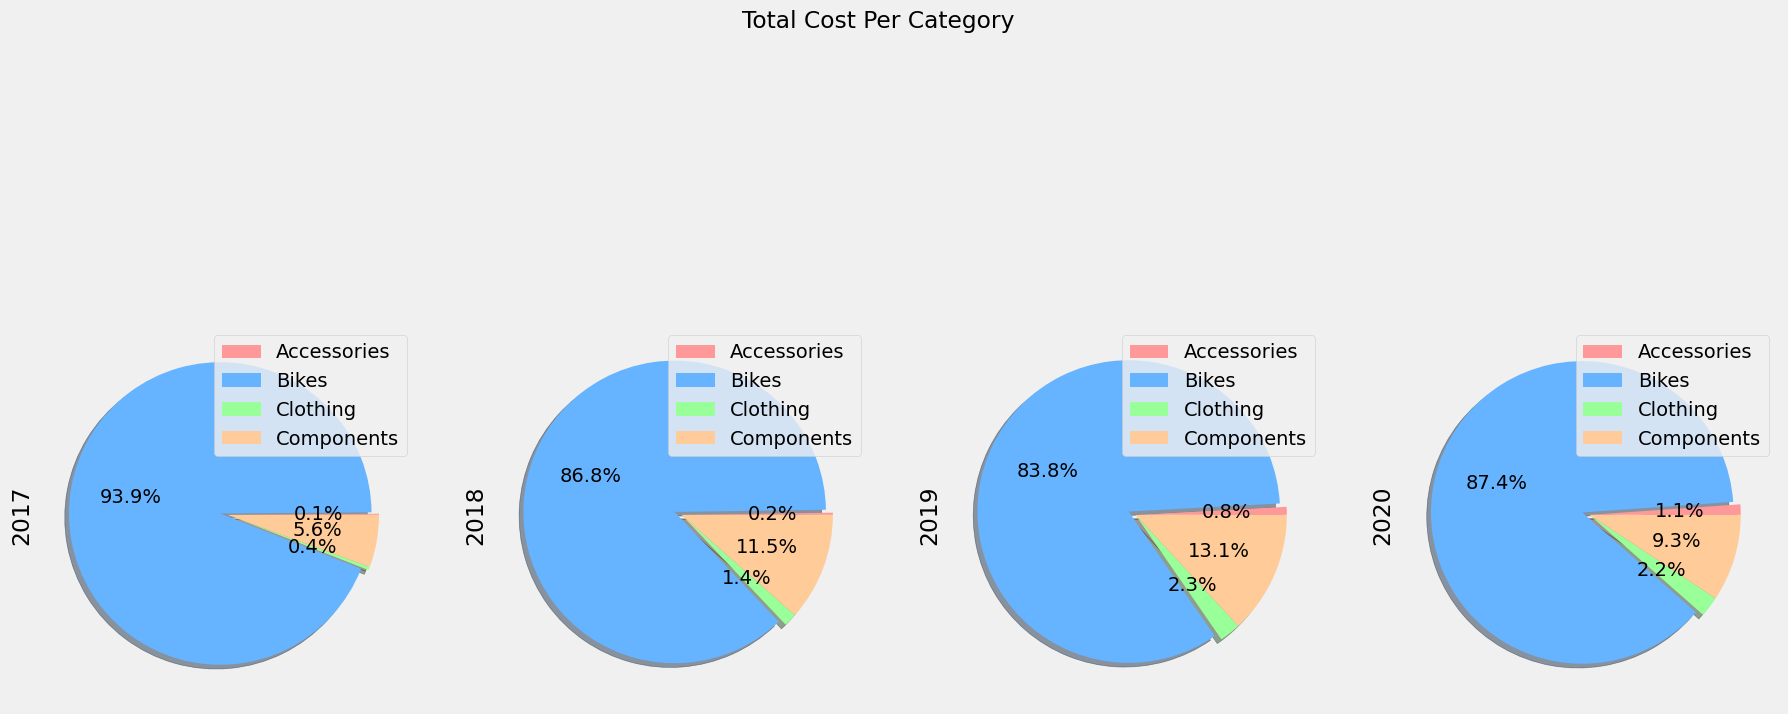

In [8]:
# Total Cost Analysis
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
yearly_categories_sale = sales_data.groupby([sales_data['OrderDateKey'].dt.year, sales_data['Category']])['total_cost'].sum()
yearly_categories_sale = pd.DataFrame(yearly_categories_sale)
yearly_categories_sale = yearly_categories_sale.reset_index().pivot(index = 'Category',columns = 'OrderDateKey', values='total_cost')
yearly_categories_sale.plot.pie(subplots=True, figsize = (20,10), autopct='%1.1f%%', shadow=True, explode=[0.00, 0.05,0,0], colors=colors, legend=True, title='Total Cost Per Category',  labeldistance=None)
plt.show()

### Observations
- Bikes have been dominating when it comes how Total Cost in each year from 2018, 2019 and 2020.
- There has been increase in Cost of accessories over the years, starting from 0.9% in 2018 to 7.9% in 2020.

## Top Resellers and Customers

In [9]:
## reference
## https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [10]:
sales_data_reseller = sales_data.loc[sales_data['Channel']=='Reseller']
top_r = sales_data_reseller.groupby([sales_data['OrderDateKey'].dt.year, sales_data['Reseller']]).agg({'net_sales':sum}).sort_values('net_sales', ascending=False).reset_index().groupby(['OrderDateKey']).head(3).sort_values('OrderDateKey')
sales_data_customer = sales_data.loc[sales_data['Channel']=='Internet']
top_c = sales_data_customer.groupby([sales_data['OrderDateKey'].dt.year, sales_data['Customer']]).agg({'net_sales':sum}).sort_values('net_sales', ascending=False).reset_index().groupby(['OrderDateKey']).head(3).sort_values('OrderDateKey')

display_side_by_side(dfs = [top_r,top_c], captions=['Top 3 Reseller Per Year','Top 3 Customers Per Year'])

,OrderDateKey,Reseller,net_sales
45,2017,Hardware Components,14576.615700
51,2017,Tread Industries,14077.897600
62,2017,Golf and Cycle Store,13544.717700
12,2018,The Gear Store,23357.286200
16,2018,Brakes and Gears,21639.076800
17,2018,Great Bikes,21589.884600
0,2019,Field Trip Store,33901.938100
1,2019,Top Sports Supply,32902.150700
2,2019,Registered Cycle Store,31768.116800
55,2020,Top Sports Supply,13749.315600


### Observations
- The Tables above shows top 3 Resellers and 3 Customers each year

## Understanding Net Sales of Customers and Resellers 

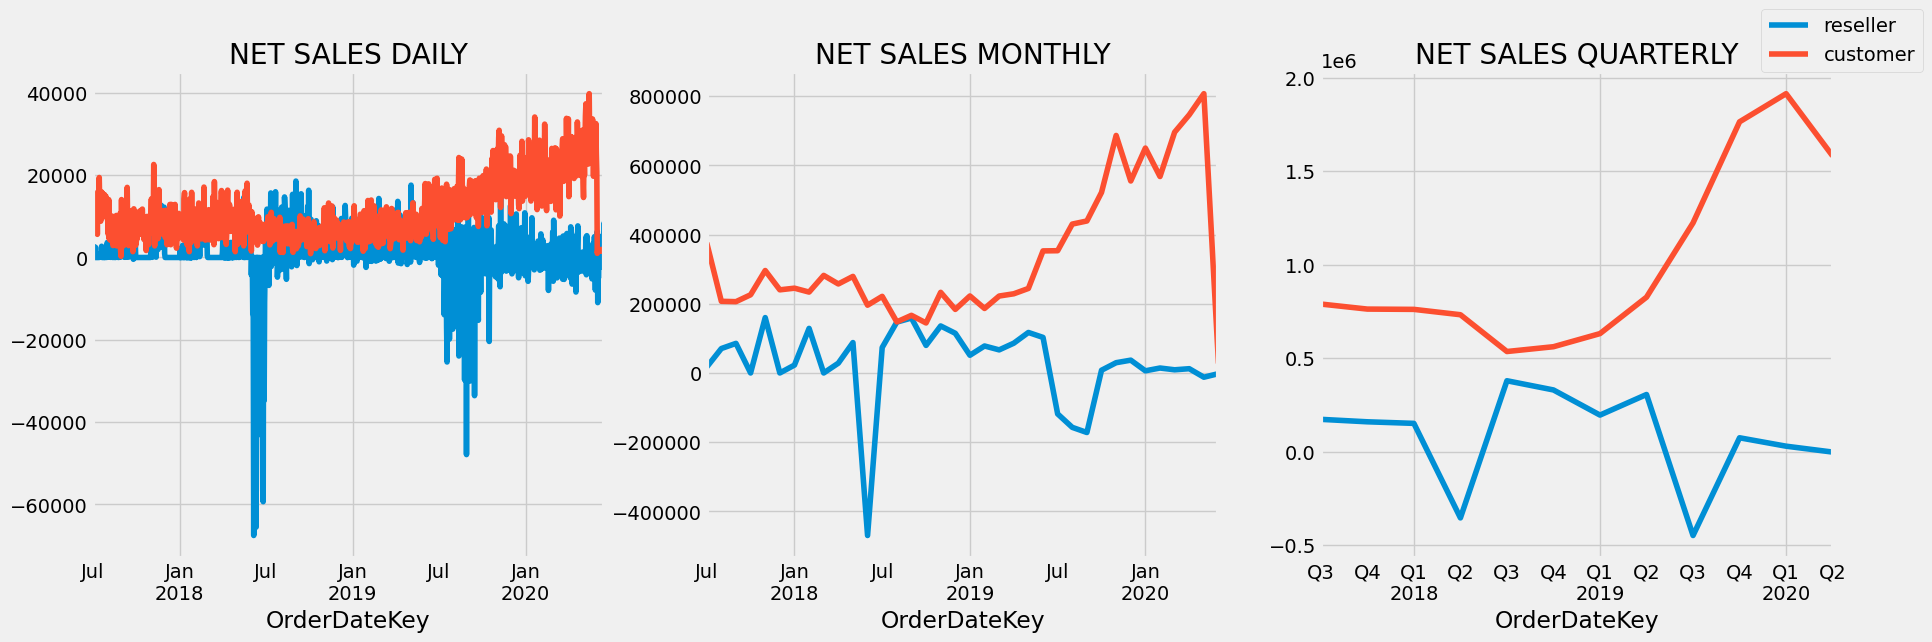

In [11]:
# Understanding periodic sales of customers and Resellers 

def plot_sales_periodic(sales_data):
    """
    Function to plot the sales info based on input period
    """
    period_label = {'d':'DAILY', 'm':'MONTHLY', 'q':'QUARTERLY'}
    fig, ax = plt.subplots(1, 3, figsize=  (20,6))
    r = sales_data.loc[sales_data['Channel']=='Reseller']
    c = sales_data.loc[sales_data['Channel']=='Internet']
    for i,p in enumerate(['d','m', 'q']):
        r.set_index('OrderDateKey').resample(p).sum()['net_sales'].plot(title = 'NET SALES {}'.format(period_label[p]), ax = ax[i], )
        c.set_index('OrderDateKey').resample(p).sum()['net_sales'].plot(title = 'NET SALES {}'.format(period_label[p]), ax=ax[i], )
    fig.legend(['reseller', 'customer'])
    fig.show()

plot_sales_periodic(sales_data)



### Observations
- Net Sales from Reseller are not very appealing. On the other hand, the sales from the Internet (Direct Customer) is consistent and rising.
- The Drop in sales in march 2020 must be because of covid.
- Sales from the reseller has a pattern, sales go down dramatically in Q2-Q3(This can seen in plots 2018 Jul and 2019 jul)


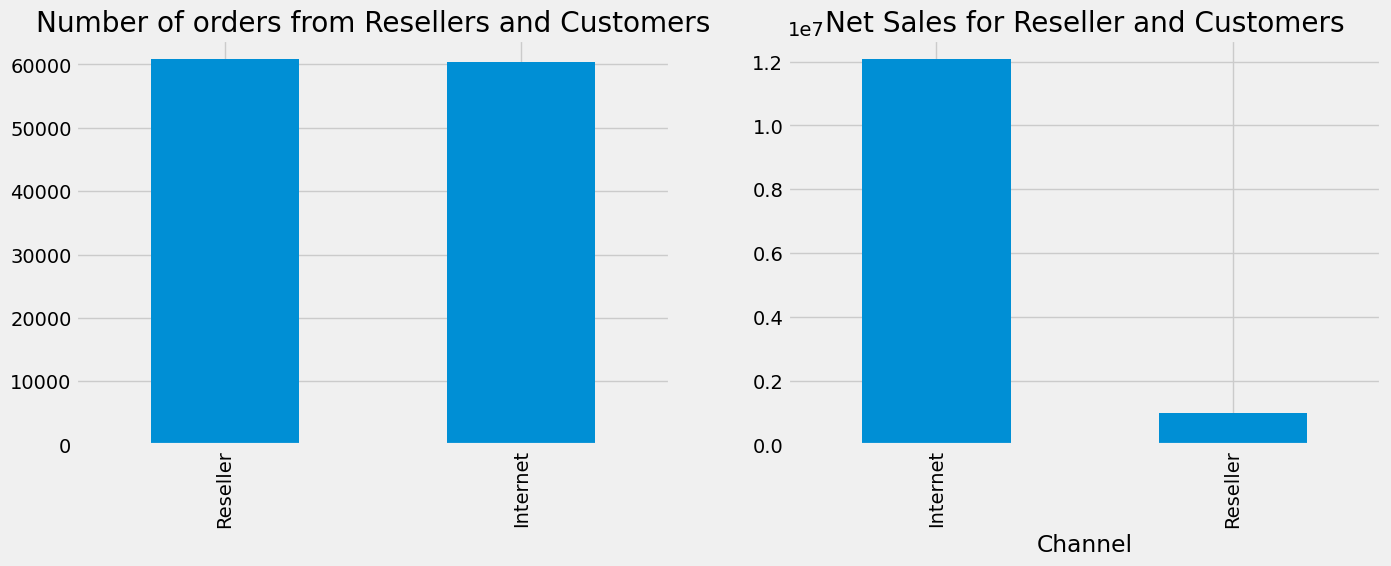

In [12]:
## Number of Orders from Resellers and Customers
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
sales_data['Channel'].value_counts().plot.bar(title = 'Number of orders from Resellers and Customers', ax = ax1)
sales_data.groupby('Channel')['net_sales'].sum().plot.bar(title = 'Net Sales for Reseller and Customers', ax = ax2)
fig.show()

- Number of Order are same for both Resellers and Customers but overall sales are much higher for Customers when compared to Resellers
### All Things Considered, I suggest MABJ Corp should work Only with Customers (atleast utill the reason for drop in sales for resellers in Q2-Q3 is identified and fixed.)

## Deliverable 2
## Forecasting Sales for the Best selected type of Channel (Internet/Customers)

In [13]:
# creating the train data for customers
features = ['OrderDateKey','Customer','Category','Country','net_sales']
customers_data = sales_data.loc[sales_data['Channel']=='Internet', features]
customers_data['day'], customers_data['month'], customers_data['year'] = customers_data['OrderDateKey'].dt.day, customers_data['OrderDateKey'].dt.month, customers_data['OrderDateKey'].dt.year
customers_data = customers_data.drop('OrderDateKey', axis=1)
customers_data.head()

,Customer,Category,Country,net_sales,day,month,year
866,Jenny Nath,Bikes,United States,953.5637,28,4,2019
2006,Cheryl Dominguez,Bikes,United States,1043.0087,15,4,2020
2250,Cheryl Dominguez,Clothing,United States,12.4177,15,4,2020
2348,Albert Castro,Accessories,United States,21.9037,15,6,2020
2450,Jay Romero,Accessories,United States,75.1200,4,10,2019


In [14]:
# Splitting the dataset into train and test
train, test = train_test_split(customers_data, shuffle = False) # we should make sure we are splitting in time sensitive manner

In [15]:
# seperate independent variables and target variable
X_train,y_train = train.drop('net_sales', axis=1), train['net_sales']
X_test,y_test = test.drop('net_sales', axis=1), test['net_sales']

In [16]:
# creating the model flow pipeline including preprocessing, model building along with hyper parameter tuning
features_for_labelencoder = ['Customer',]
features_for_onehotencoder = ['Country', 'Category']
one_hot_encoder = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)
label_encoder = Pipeline(
    [
        ('label', OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value = -1))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('onehot', one_hot_encoder, features_for_onehotencoder),
        ('label', label_encoder, features_for_labelencoder),
       
    ],
    remainder = 'passthrough'
)

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('reg', RandomForestRegressor())
    ]
)
params = {
    'reg__max_depth': [4,8,12],
}


cv = GridSearchCV(pipeline, params, n_jobs = -1)

In [17]:
# Training the model
cv.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Country',
                                                                          'Category']),
                                                                        ('label',
                                                                         Pipeline(steps=[('label',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Customer'])])),
                                       ('reg', RandomForestRegressor())]),
             n_jobs=-1, param_grid={'reg__max_depth': [4, 8, 12]})

In [18]:
cv.best_params_

{'reg__max_depth': 4}

In [19]:
# helper function to get the performance metrics
# Reference https://towardsdatascience.com/model-evaluation-in-scikit-learn-abce32ee4a99
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import numpy as np
def get_performance(y_test, y_pred):
    print("R^2 : {:.3f}".format( r2_score(y_test, y_pred)))
    print("MAE : {:.3f}".format( mean_absolute_error(y_test,y_pred)))
    print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

In [20]:
# get the traini performance
print('Train Performance')
y_pred_train = cv.predict(X_train)

get_performance(y_train, y_pred_train)

Train Performance
R^2 : 0.820
MAE : 77.924
RMSE: 162.934


In [21]:
# test performance
print('Test Performance')
y_pred = cv.predict(X_test)

get_performance(y_test, y_pred)

Test Performance
R^2 : 0.790
MAE : 81.222
RMSE: 166.284


## Models has 0.8 R-square. this can used to forecast net sales for customers

#### Testing models performance for fake entries

In [22]:
fake_entry = pd.DataFrame({'Customer' : 'Jarrod Rana',	'Category':'Accessories', 'Country':'France',	'day':7,	'month':3,	'year':2023}, index = [0])
fake_entry

,Customer,Category,Country,day,month,year
0,Jarrod Rana,Accessories,France,7,3,2023


In [23]:
pred_sales = cv.predict(fake_entry)
print('Net Sales for the given entry is {:3f}'.format(pred_sales[0]))

Net Sales for the given entry is 16.199158


In [24]:
fake_entry2 = pd.DataFrame({'Customer' : 'Benjamin Flores',	'Category':'Clothing', 'Country':'United Kingdom',	'day':7,	'month':3,	'year':2023}, index = [0])
fake_entry2

,Customer,Category,Country,day,month,year
0,Benjamin Flores,Clothing,United Kingdom,7,3,2023


In [25]:
pred_sales = cv.predict(fake_entry2)
print('Net Sales for the given entry is {:3f}'.format(pred_sales[0]))

Net Sales for the given entry is 17.043615
